In [ ]:
import torchvision
import os
from ffcv.writer import DatasetWriter
from ffcv.fields import RGBImageField, IntField
import torch
import src.pytorch_datasets as pytorch_datasets
from src import ffcv_utils
import yaml
from src.config_parsing import ffcv_read_check_override_config
import pprint
from src.ffcv_utils import get_training_loaders
from src.pytorch_datasets import create_val_split, get_unlabeled_indices, IndexedDataset
from robustness.tools.vis_tools import show_image_row

In [ ]:
def test_dataset(config, pipeline_subset=['image', 'label', 'index']):
    with open(f"dataset_configs/{config}", 'r') as file:
        hparams = yaml.safe_load(file)
    hparams = ffcv_read_check_override_config(hparams)
    print("=========== Current Config ==================")
    pprint.pprint(hparams, indent=4)
    train_loader, val_loader, test_loader = get_training_loaders(hparams, pipeline_subset=pipeline_subset)
    return train_loader, val_loader, test_loader

In [4]:
train_load, val_load, test_load = test_dataset('imagenet_c.yaml', pipeline_subset=['image', 'label', 'spurious', 'index'])

Using default os_cache: False
Using default quasi_random: True
Using default train_aug: None
Using default val_aug: None
Using default loss_vec_file: None
Using default val_beton: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
=========== Current Config ==================
{   'arch': 'resnet18',
    'arch_type': 'resnet',
    'batch_size': 256,
    'drop_last': True,
    'imgsz': 224,
    'indices_file': 'index_files/imagenet_indices.pt',
    'loss_upweight': 5,
    'loss_vec_file': None,
    'mean': [123.675, 116.28, 103.53],
    'num_classes': 1000,
    'num_workers': 10,
    'os_cache': False,
    'quasi_random': True,
    'shuffle': True,
    'std': [58.395, 57.12, 57.375],
    'test_beton': '/home/gridsan/hanlaw/CorrErrs_shared/betons/imagenet_c/train_3_0p1_val_3_0p8/train_3_0p1_val_3_0p8_test.beton',
    'train_aug': None,
    'train_beton': '/home/gridsan/hanlaw/CorrErrs_shared/betons/imagenet_c/train_3_0p1_val_3_0p8/train_3_0p1_val_3_0p8_train.beton',
 

# Imagenet

In [19]:
data_dir = '/home/gridsan/hanlaw/CorrErrs_shared/datasets/DistortedImageNet/JPEG/val/gaussian_noise/0/0.8/'
# /home/gridsan/hanlaw/CorrErrs_shared/datasets/DistortedImageNet/JPEG/val/gaussian_noise/3/0.1/
supervised_file_path = data_dir + 'distorted_indices'
with open(supervised_file_path,'r') as f:
    distorted_inds=[]
    distorted_inds_dict = {}
    for line in f:
        strnum = line.rstrip()
        distorted_ind = float(strnum)
        distorted_inds.append(distorted_ind)
        distorted_inds_dict[distorted_ind] = 1
print('No repeats: ', len(set(distorted_inds))==len(distorted_inds))

      

No repeats:  True


In [20]:
len(set(distorted_inds))

4885

In [25]:
set(distorted_inds_dict.keys())

{40960.0,
 16385.0,
 32770.0,
 49153.0,
 8196.0,
 49156.0,
 49157.0,
 32775.0,
 8200.0,
 8201.0,
 32779.0,
 8206.0,
 40975.0,
 32785.0,
 20.0,
 24596.0,
 40982.0,
 49172.0,
 40985.0,
 29.0,
 16415.0,
 24608.0,
 8225.0,
 8226.0,
 49183.0,
 36.0,
 16423.0,
 24617.0,
 49193.0,
 49194.0,
 49195.0,
 16429.0,
 49196.0,
 49197.0,
 32816.0,
 49201.0,
 16434.0,
 16435.0,
 24628.0,
 41015.0,
 8248.0,
 8251.0,
 24636.0,
 24637.0,
 41023.0,
 41024.0,
 24641.0,
 49216.0,
 8259.0,
 8260.0,
 16452.0,
 24643.0,
 71.0,
 24644.0,
 24646.0,
 16458.0,
 24649.0,
 16460.0,
 24651.0,
 41038.0,
 49224.0,
 80.0,
 49232.0,
 41042.0,
 32851.0,
 8281.0,
 24666.0,
 32857.0,
 93.0,
 32861.0,
 32862.0,
 96.0,
 32865.0,
 8290.0,
 41053.0,
 49246.0,
 32869.0,
 103.0,
 16487.0,
 16489.0,
 32871.0,
 41066.0,
 108.0,
 16492.0,
 24685.0,
 8303.0,
 32878.0,
 49264.0,
 32884.0,
 16501.0,
 8310.0,
 24695.0,
 24698.0,
 41083.0,
 16509.0,
 32893.0,
 41086.0,
 32896.0,
 41089.0,
 16515.0,
 16516.0,
 32899.0,
 41091.0,
 8327.0,


In [23]:
print('No repeats: ', len(set(distorted_inds_dict.keys()))==len(distorted_inds_dict.keys()))

No repeats:  True


In [ ]:
import torch
class ImagenetC(torch.utils.data.Dataset):
    def __init__(self, ds, supervised_file_path): #indices, return_all_attr): #supervised_key
        # indices should have the key inds which is indices to extract
        # all other keys are annotation information
        # supervised_key is the key name of the supervised label
        # if return_all_attr is True then also return the full dict of attr info
        self.ds = ds
        self.supervised_file_path = supervised_file_path 
        
        with open(supervised_file_path,'r') as f:
            for line in f:
                distorted_inds=[]
                distorted_inds_dict = {}
                for line in f:
                    strnum = line.rstrip()
                    distorted_ind = float(strnum)
                    distorted_inds.append(distorted_ind)
                    distorted_inds_dict[distorted_ind] = 1
            print('No repeats: ', len(set(distorted_inds))==len(distorted_inds))
        
        self.distorted_inds_dict = distorted_inds_dict
        self.distorted_inds = distorted_inds
        
        # generate list based on this!
        
        #self.indices = indices
        #assert 'inds' in self.indices
        #self.return_all_attr = return_all_attr
        
        """if weights is None:
            self.weights = torch.ones(len(indices['inds']))
        else:
            self.weights = weights
        self.supervised_key = supervised_key
        self.other_keys = [k for k in self.indices.keys() if k != 'inds']
        
        assert supervised_key in self.indices"""
        
    def __len__(self):
        return len(self.ds) #len(self.indices['inds'])
    
    def __getitem__(self, idx):
        #ds_index = self.indices['inds'][idx]
        x, y = self.ds[idx] #ds_index]
        spurious = (idx in self.distorted_inds_dict.keys())
        return x, y, spurious
        
        # ALSO: sanity check distorted inds, that images look distorted vs not, etc 
        
        # CHECK WHAT INDICES HAS: use distorted_inds_dict here instead?
        """y = self.indices[self.supervised_key][idx] 
        weight = self.weights[idx]
        if self.return_all_attr:
            meta = {k: self.indices[k][idx] for k in self.other_keys}
            return x, y, meta, weight
        else:
            return x, y"""

In [71]:
data_dir = '/home/gridsan/hanlaw/CorrErrs_shared/datasets/DistortedImageNet/JPEG/val/gaussian_noise/0/0.8/'
# /home/gridsan/hanlaw/CorrErrs_shared/datasets/DistortedImageNet/JPEG/val/gaussian_noise/3/0.1/
supervised_file_path = data_dir + 'distorted_indices'
distorted_dataset = dset.ImageFolder(
            root=data_dir,
            transform=trn.Compose([trn.CenterCrop(224), trn.ToTensor(), trn.Normalize(mean, std)]))
tryINC = ImagenetC(distorted_dataset, supervised_file_path)
spur_loader = torch.utils.data.DataLoader(tryINC, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)




No repeats:  True


In [72]:
tryINC.distorted_inds_dict[0]
tryINC.distorted_inds

KeyError: 0

In [73]:
tryINC.distorted_inds

[1.0,
 100.0,
 301.0,
 201.0,
 101.0,
 2.0,
 3.0,
 302.0,
 103.0,
 204.0,
 205.0,
 304.0,
 206.0,
 305.0,
 5.0,
 104.0,
 207.0,
 307.0,
 105.0,
 308.0,
 208.0,
 106.0,
 309.0,
 7.0,
 107.0,
 310.0,
 8.0,
 311.0,
 9.0,
 110.0,
 209.0,
 312.0,
 210.0,
 111.0,
 211.0,
 112.0,
 313.0,
 314.0,
 315.0,
 213.0,
 114.0,
 214.0,
 316.0,
 115.0,
 317.0,
 318.0,
 116.0,
 319.0,
 215.0,
 216.0,
 218.0,
 219.0,
 119.0,
 220.0,
 221.0,
 120.0,
 222.0,
 121.0,
 10.0,
 122.0,
 320.0,
 223.0,
 11.0,
 321.0,
 224.0,
 12.0,
 225.0,
 322.0,
 226.0,
 323.0,
 125.0,
 126.0,
 324.0,
 228.0,
 14.0,
 127.0,
 325.0,
 229.0,
 128.0,
 230.0,
 231.0,
 326.0,
 232.0,
 233.0,
 234.0,
 16.0,
 235.0,
 129.0,
 329.0,
 17.0,
 130.0,
 236.0,
 18.0,
 237.0,
 131.0,
 238.0,
 19.0,
 332.0,
 132.0,
 239.0,
 333.0,
 133.0,
 20.0,
 334.0,
 134.0,
 21.0,
 242.0,
 335.0,
 135.0,
 22.0,
 23.0,
 336.0,
 244.0,
 24.0,
 137.0,
 337.0,
 338.0,
 245.0,
 26.0,
 138.0,
 339.0,
 247.0,
 27.0,
 340.0,
 248.0,
 139.0,
 28.0,
 341.0,
 140.0

In [52]:
spurious.shape

torch.Size([128])

spurious tensor(97) tensor(15)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

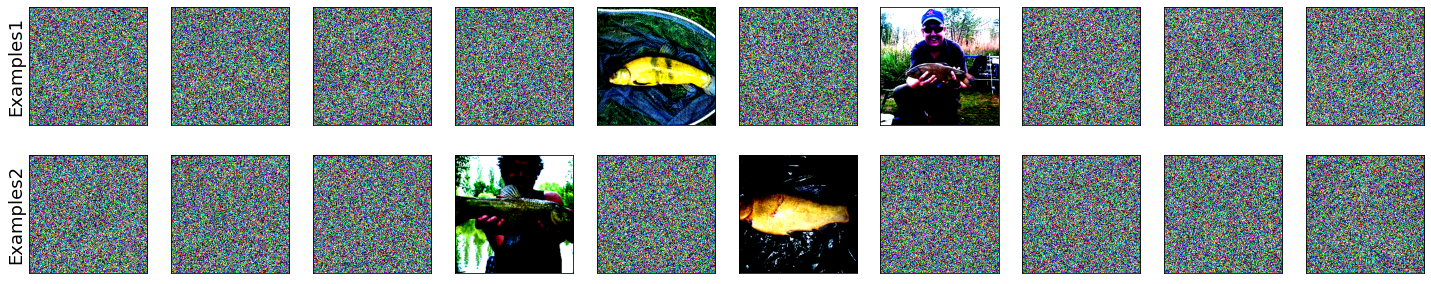

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([False,  True,  True,  True, False,  True, False,  True,  True,  True])
--
tensor([ True,  True,  True, False,  True, False,  True,  True,  True,  True])
spurious tensor(98) tensor(17)


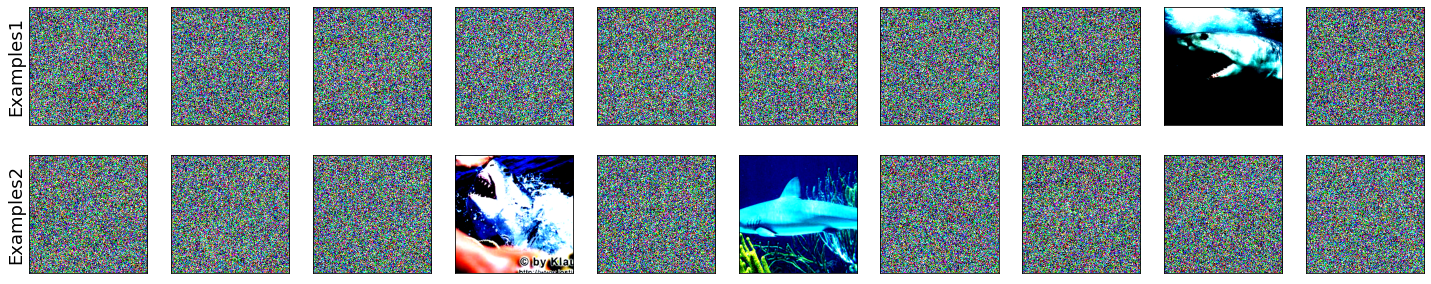

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True])
--
tensor([ True,  True,  True, False,  True, False,  True,  True,  True,  True])
spurious tensor(104) tensor(16)


In [74]:
count=1
for x,y,spurious in spur_loader:
    print('spurious', spurious.sum(), spurious[0:20].sum())
    if count>2:
        break
    count=count+1
    show_image_row([x[0:10], x[10:20]],
             ["Examples1", "Examples2"],
             fontsize=18,
             filename="./ignore.png")

    print(spurious[0:10])
    print('--')
    print(spurious[10:20])

In [53]:
print(spurious[0:10])
print('--')
print(spurious[10:20])

tensor([False, False,  True, False, False, False, False, False,  True, False])
--
tensor([False, False, False, False, False, False, False, False, False, False])


In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as trn
import torch

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


# '/home/gridsan/hanlaw/CorrErrs_shared/datasets/DistortedImageNet/JPEG/gaussian_noise/1'
data_dir = '/home/gridsan/hanlaw/CorrErrs_shared/datasets/DistortedImageNet/JPEG/val/gaussian_noise/3/0.8/'
#data_dir = '/home/gridsan/hanlaw/CorrErrs_shared/datasets/DistortedImageNet/JPEG/val/gaussian_noise/0/0.8/'
# /home/gridsan/hanlaw/CorrErrs_shared/datasets/DistortedImageNet/JPEG/val/gaussian_noise/3/0.1/
supervised_file_path_val = data_dir + 'distorted_indices'
distorted_dataset_val = dset.ImageFolder(
            root=data_dir,
            transform=trn.Compose([trn.CenterCrop(224)])) #, trn.ToTensor(), trn.Normalize(mean, std)]))

train_dir = '/home/gridsan/hanlaw/CorrErrs_shared/datasets/DistortedImageNet/JPEG/train/gaussian_noise/3/0.1/'
# NEED TO MAKE A WRAPPER THAT INCLUDES ATTRIBUTE (distorted or not) 
supervised_file_path_train = data_dir + 'distorted_indices'
distorted_dataset_train = dset.ImageFolder(
            root=train_dir,
            transform=trn.Compose([trn.CenterCrop(224)])) #, trn.ToTensor(), trn.Normalize(mean, std)]))

final_val = ImagenetC(distorted_dataset_val, supervised_file_path_val)
final_train = ImagenetC(distorted_dataset_train, supervised_file_path_train)

#distorted_dataset_loader = torch.utils.data.DataLoader(
#    distorted_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

#BETON_ROOT = '/home/gridsan/hanlaw/CorrErrs_shared/betons'
#write_celeba_betons('imagenet_c_train_3_0p1_val_3_0p8', final_train, final_val, val_ds=None)


#for batch in distorted_dataset_loader:
#    break
#print(batch[1].shape, batch[1])

In [31]:
len(distorted_dataset)

49997

In [ ]:
def create_val_split_from_test(train_targets, test_targets, num_classes, split_amt=5):
    N = len(test_targets)
    val_indices = []
    for c in range(num_classes):
        val_indices.append(torch.arange(N)[test_targets == c][::split_amt])
    val_indices = torch.cat(val_indices)
    test_indices = torch.tensor([u for u in torch.arange(N) if u not in val_indices])
    Ntrain = len(train_targets)
    train_indices = torch.tensor([u for u in torch.arange(Ntrain)])
    indices_dict = {
        'val_indices': val_indices,
        'train_indices': train_indices,
        'test_indices': test_indices,
    }
    return indices_dict

In [2]:
def create_val_split(train_targets, num_classes, split_amt=5):
    N = len(train_targets)
    val_indices = []
    for c in range(num_classes):
        val_indices.append(torch.arange(N)[train_targets == c][::split_amt])
    val_indices = torch.cat(val_indices)
    train_indices = torch.tensor([u for u in torch.arange(N) if u not in val_indices])
    indices_dict = {
        'val_indices': val_indices,
        'train_indices': train_indices,
    }
    return indices_dict

In [76]:
class IndexedDataset():
    def __init__(self, ds):
        self.ds = ds
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        return *self.ds[idx], idx

In [4]:
BETON_ROOT = "/mnt/nfs/home/saachij/betons/"

In [80]:
def write_betons(ds_name, train_ds, test_ds, val_ds=None):
    os.makedirs(os.path.join(BETON_ROOT, ds_name), exist_ok=True)
    ds_pairs = [
        ['train', train_ds],
        ['test', test_ds]
    ]
    if val_ds is not None:
        ds_pairs.append(['val', val_ds])
    
    for split_name, ds in ds_pairs:
        ds = IndexedDataset(ds)
        write_path = os.path.join(BETON_ROOT, ds_name, f"{ds_name}_{split_name}.beton")
        # Pass a type for each data field
        writer = DatasetWriter(write_path, {
            # Tune options to optimize dataset size, throughput at train-time
            'image': RGBImageField(),
            'label': IntField(),
            'index': IntField(),
        })

        # Write dataset
        writer.from_indexed_dataset(ds)

def write_imagenet_c_betons(ds_name, train_ds, test_ds, val_ds=None):
    os.makedirs(os.path.join(BETON_ROOT, ds_name), exist_ok=True)
    ds_pairs = [
        ['train', train_ds]
        #['test', test_ds]
    ]
    if val_ds is not None:
        ds_pairs.append(['val', val_ds])
    
    for split_name, ds in ds_pairs:
        ds = IndexedDataset(ds)
        write_path = os.path.join(BETON_ROOT, ds_name, f"{ds_name}_{split_name}.beton")
        # Pass a type for each data field
        writer = DatasetWriter(write_path, {
            # Tune options to optimize dataset size, throughput at train-time
            'image': RGBImageField(max_resolution=75),
            'label': IntField(),
            'spurious': IntField(),
            'index': IntField(),
        })

        # Write dataset
        writer.from_indexed_dataset(ds)

def write_celeba_betons(ds_name, train_ds, test_ds, val_ds=None):
    os.makedirs(os.path.join(BETON_ROOT, ds_name), exist_ok=True)
    ds_pairs = [
        ['train', train_ds],
        ['test', test_ds]
    ]
    if val_ds is not None:
        ds_pairs.append(['val', val_ds])
    
    for split_name, ds in ds_pairs:
        ds = IndexedDataset(ds)
        write_path = os.path.join(BETON_ROOT, ds_name, f"{ds_name}_{split_name}.beton")
        # Pass a type for each data field
        writer = DatasetWriter(write_path, {
            # Tune options to optimize dataset size, throughput at train-time
            'image': RGBImageField(max_resolution=75),
            'label': IntField(),
            'spurious': IntField(),
            'index': IntField(),
        })

        # Write dataset
        writer.from_indexed_dataset(ds)
        


## CIFAR10

In [ ]:
orig_ds_path = '/home/gridsan/hanlaw/CorrErrs_shared/datasets/cifar-10-batches-py' #"/mnt/nfs/home/saachij/datasets/cifar"
train_ds = torchvision.datasets.CIFAR10(orig_ds_path, train=True)
test_ds = torchvision.datasets.CIFAR10(orig_ds_path, train=False)


In [8]:
write_betons('cifar', train_ds, test_ds, val_ds=None)
indices_dict = create_val_split(torch.tensor(train_ds.targets), 10, 5)
torch.save(indices_dict, 'index_files/cifar_indices.pt')

100%|██████████| 10000/10000 [00:00<00:00, 99637.82it/s]


In [30]:
num_classes = 10
# write subsets
for fold in [2, 4, 5, 10]:
    indices_dict = create_val_split(torch.tensor(train_ds.targets), 10, 5)
    base_inds = indices_dict['train_indices']
    sub_indices_dict = create_val_split(torch.tensor(train_ds.targets)[base_inds], num_classes, fold)
    result_indices = {
        'train_indices': base_inds[sub_indices_dict['val_indices']],
        'unlabeled_indices': base_inds[sub_indices_dict['train_indices']],
        'val_indices': indices_dict['val_indices']
    }
    print("--", fold, "--")
    for k, v in result_indices.items():
        print(k, len(v))
    torch.save(result_indices, f'index_files/cifar_indices_{fold}.pt')

-- 2 --
train_indices 20000
unlabeled_indices 20000
val_indices 10000
-- 4 --
train_indices 10000
unlabeled_indices 30000
val_indices 10000
-- 5 --
train_indices 8000
unlabeled_indices 32000
val_indices 10000
-- 10 --
train_indices 4000
unlabeled_indices 36000
val_indices 10000


In [ ]:
train_loader, val_loader, test_loader = test_dataset('cifar_mslurm.yaml')

for batch in train_loader:
    break

Using default os_cache: False
Using default quasi_random: True
Using default val_aug: None
Using default loss_vec_file: None
Using default val_beton: None
Using default loss_upweight: 5
=========== Current Config ==================
{   'arch': 'resnet18',
    'arch_type': 'cifar_resnet',
    'batch_size': 512,
    'drop_last': True,
    'imgsz': 32,
    'indices_file': 'index_files/cifar_indices.pt',
    'loss_upweight': 5,
    'loss_vec_file': None,
    'mean': [125.307, 122.961, 113.8575],
    'num_classes': 10,
    'num_workers': 1,
    'os_cache': False,
    'quasi_random': True,
    'shuffle': True,
    'std': [51.5865, 50.847, 51.255],
    'test_beton': '/mnt/nfs/home/saachij/betons/cifar/cifar_test.beton',
    'train_aug': 'cifar_train_aug',
    'train_beton': '/mnt/nfs/home/saachij/betons/cifar/cifar_train.beton',
    'train_img_decoder': 'simple',
    'training': {   'epochs': 24,
                    'lr': 0.5,
                    'lr_scheduler': {'lr_peak_epoch': 5, 'type': '

## CIFAR 100

In [ ]:
orig_ds_path = "/mnt/nfs/home/saachij/datasets/cifar100"
train_ds = torchvision.datasets.CIFAR100(orig_ds_path, train=True)
test_ds = torchvision.datasets.CIFAR100(orig_ds_path, train=False)

In [9]:
get_unlabeled("cifar100", torch.tensor(train_ds.targets), 100, [2])

-- 2 --
train_indices 20000
unlabeled_indices 20000
val_indices 10000


In [ ]:
write_betons('cifar100', train_ds, test_ds, val_ds=None)
indices_dict = create_val_split(torch.tensor(train_ds.targets), 100, 5)
torch.save(indices_dict, 'index_files/cifar100_indices.pt')

## Super CIFAR100

In [6]:
write_betons('supercifar100', train_ds, test_ds, val_ds=None)
indices_dict = create_val_split(torch.tensor(train_ds.targets), 20, 5)
torch.save(indices_dict, 'index_files/supercifar100_indices.pt')

100%|██████████| 10000/10000 [00:00<00:00, 99625.75it/s]


get_unlabeled("supercifar100", torch.tensor(train_ds.targets), 20, [2])

In [7]:
train_ds.classes

['aquatic mammals',
 'fish',
 'flowers',
 'food containers',
 'fruit and vegetables',
 'household electrical devices',
 'household furniture',
 'insects',
 'large carnivores',
 'large man-made outdoor things',
 'large natural outdoor scenes',
 'large omnivores and herbivores',
 'medium-sized mammals',
 'non-insect invertebrates',
 'people',
 'reptiles',
 'small mammals',
 'trees',
 'vehicles 1',
 'vehicles 2']

In [65]:
# get spurious
import numpy as np
classes_to_drop = []
orig_indices = torch.load("index_files/supercifar100_indices_2.pt")
subclass_targets = np.array(train_ds.subclass_targets)
targets = np.array(train_ds.targets)
for c in range(20):
    class_to_drop = np.unique(np.array(subclass_targets[targets == c]))
    classes_to_drop.append(class_to_drop[0])
new_train_indices = []
for c in range(100):
    mask = subclass_targets[orig_indices['train_indices']] == c
    if c in classes_to_drop:
        new_train_indices.append(orig_indices['train_indices'][mask][::7])
    else:
        new_train_indices.append(orig_indices['train_indices'][mask])
new_train_indices = torch.cat(new_train_indices)
orig_indices['train_indices'] = new_train_indices
orig_indices['classes_to_drop'] = torch.tensor(classes_to_drop)
torch.save(orig_indices, 'index_files/spurious_supercifar100_indices.pt')

In [64]:
classes_to_drop

[4, 1, 54, 9, 0, 22, 5, 6, 3, 12, 23, 15, 34, 26, 2, 27, 36, 47, 8, 41]

## CelebA

In [8]:
train_ds = pytorch_datasets.SpuriousAttributeCelebA(root="/mnt/nfs/datasets/celeba", split='train') 
val_ds = pytorch_datasets.SpuriousAttributeCelebA(root="/mnt/nfs/datasets/celeba", split='valid') 
test_ds = pytorch_datasets.SpuriousAttributeCelebA(root="/mnt/nfs/datasets/celeba", split='test') 
write_celeba_betons('celeba', train_ds, test_ds, val_ds)

100%|██████████| 19867/19867 [00:04<00:00, 4037.00it/s]


### Compute Training Splits

In [9]:
import numpy as np
is_male = train_ds.male_targets == 1
is_blond = train_ds.blond_hair_targets == 1
is_black_hair = train_ds.black_hair_targets == 1

male_and_blond = is_male & is_blond
male_and_black_hair = is_male & (is_black_hair)
female_and_blond = (~is_male) & is_blond
female_and_black_hair = (~is_male) & (is_black_hair)

overall_indices = torch.arange(len(train_ds))

In [10]:
# 1 to 7 split
K = 7
np.random.seed(10)
taken_male_and_blond = overall_indices[male_and_blond]
lowest = len(taken_male_and_blond)
taken_male_and_black_hair = np.random.choice(overall_indices[male_and_black_hair], replace=False, size=lowest*K)
taken_female_and_blond = np.random.choice(overall_indices[female_and_blond], replace=False, size=lowest*K)
taken_female_and_black_hair = np.random.choice(overall_indices[female_and_black_hair], replace=False, size=lowest)
print(len(taken_male_and_blond), len(taken_male_and_black_hair), len(taken_female_and_blond), len(taken_female_and_black_hair))
one_to_seven_train = np.concatenate([taken_male_and_blond, taken_male_and_black_hair, taken_female_and_blond, taken_female_and_black_hair])
one_to_seven_train = torch.tensor(one_to_seven_train)


1387 9709 9709 1387


In [11]:
# Extreme Split
np.random.seed(10)
taken_male_and_blond, taken_female_and_black_hair = np.array([]),  np.array([])

taken_male_and_black_hair = overall_indices[male_and_black_hair]
lowest = len(taken_male_and_black_hair)
taken_female_and_blond = np.random.choice(overall_indices[female_and_blond], replace=False, size=lowest)
print(len(taken_male_and_blond), len(taken_male_and_black_hair), len(taken_female_and_blond), len(taken_female_and_black_hair))
extreme_train = np.concatenate([taken_male_and_blond, taken_male_and_black_hair, taken_female_and_blond, taken_female_and_black_hair])
extreme_train = torch.tensor(extreme_train)


0 20122 20122 0


Val Splits

In [12]:
is_male = val_ds.male_targets == 1
is_blond = val_ds.blond_hair_targets == 1
is_black_hair = val_ds.black_hair_targets == 1

male_and_blond = is_male & is_blond
male_and_black_hair = is_male & (is_black_hair)
female_and_blond = (~is_male) & is_blond
female_and_black_hair = (~is_male) & (is_black_hair)

overall_indices = torch.arange(len(val_ds))

In [13]:
# Equal split
np.random.seed(10)
taken_male_and_blond = overall_indices[male_and_blond]
lowest = len(taken_male_and_blond)
taken_male_and_black_hair = np.random.choice(overall_indices[male_and_black_hair], replace=False, size=lowest)
taken_female_and_blond = np.random.choice(overall_indices[female_and_blond], replace=False, size=lowest)
taken_female_and_black_hair = np.random.choice(overall_indices[female_and_black_hair], replace=False, size=lowest)
print(len(taken_male_and_blond), len(taken_male_and_black_hair), len(taken_female_and_blond), len(taken_female_and_black_hair))
equal_val = np.concatenate([taken_male_and_blond, taken_male_and_black_hair, taken_female_and_blond, taken_female_and_black_hair])
equal_val = torch.tensor(equal_val)


182 182 182 182


In [14]:
all_val = overall_indices

In [15]:
for train_indices, train_name in [[one_to_seven_train, "one_to_seven_train"], [extreme_train, 'extreme_train']]:
    for val_indices, val_name in [[all_val, "all_val"], [equal_val, 'equal_val']]:
        indices_dict = {'val_indices': val_indices.long(), 'train_indices': train_indices.long()}
        torch.save(indices_dict, f"index_files/celeba_{train_name}_{val_name}.pt")

### Visualize Dataset Loader

In [16]:
import yaml
from src.config_parsing import ffcv_read_check_override_config
import pprint
from src.ffcv_utils import get_training_loaders

with open("dataset_configs/celeba.yaml", 'r') as file:
    hparams = yaml.safe_load(file)
hparams = ffcv_read_check_override_config(hparams)
print("=========== Current Config ==================")
pprint.pprint(hparams, indent=4)
train_loader, val_loader, test_loader = get_training_loaders(hparams, pipeline_subset=['image', 'label', 'spurious'])

Using default os_cache: False
Using default val_aug: None
Using default loss_vec_file: None
Using default loss_upweight: 5
=========== Current Config ==================
{   'arch': 'resnet18',
    'arch_type': 'resnet',
    'batch_size': 512,
    'drop_last': True,
    'imgsz': 64,
    'indices_file': 'index_files/celeba_one_to_seven_train_equal_val.pt',
    'loss_upweight': 5,
    'loss_vec_file': None,
    'mean': [123.675, 116.28, 103.53],
    'num_classes': 2,
    'num_workers': 1,
    'os_cache': False,
    'quasi_random': False,
    'shuffle': True,
    'std': [58.395, 57.12, 57.375],
    'test_beton': '/mnt/nfs/home/saachij/betons/celeba/celeba_test.beton',
    'train_aug': 'imagenet_train_aug',
    'train_beton': '/mnt/nfs/home/saachij/betons/celeba/celeba_train.beton',
    'train_img_decoder': 'center_crop_75',
    'training': {   'epochs': 10,
                    'lr': 0.1,
                    'lr_scheduler': {'lr_peak_epoch': 2, 'type': 'cyclic'},
                    'optimi

NameError: name 'custom_label_transforms' is not defined

In [5]:
for batch in train_loader:
    break

0 1


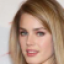

0 1


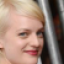

1 2


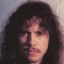

1 2


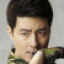

1 2


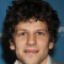

1 2


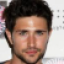

1 2


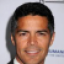

0 1


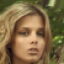

0 1


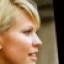

0 1


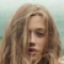

1 2


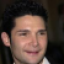

1 2


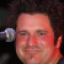

0 1


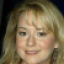

0 1


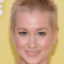

0 1


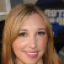

0 1


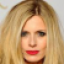

1 2


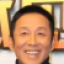

1 2


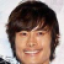

1 2


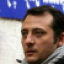

1 2


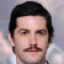

0 1


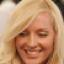

1 2


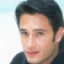

0 1


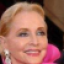

0 1


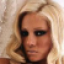

1 2


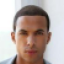

1 2


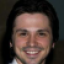

1 1


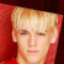

0 1


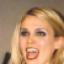

1 2


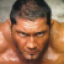

0 1


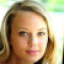

0 1


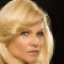

1 2


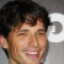

0 1


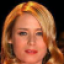

0 1


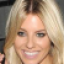

0 1


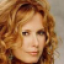

1 2


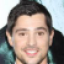

0 1


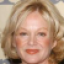

1 1


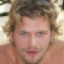

1 2


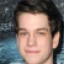

1 2


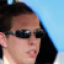

0 1


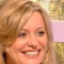

0 1


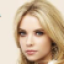

1 1


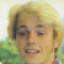

1 2


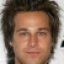

0 1


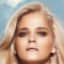

0 1


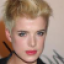

1 2


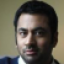

0 1


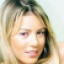

1 2


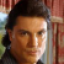

1 2


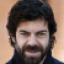

1 2


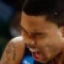

0 1


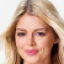

0 1


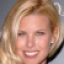

0 1


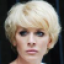

0 1


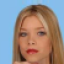

0 1


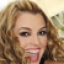

1 2


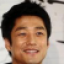

0 1


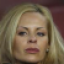

0 1


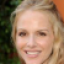

0 1


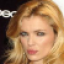

1 2


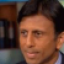

0 2


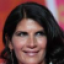

1 2


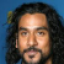

0 2


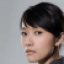

1 2


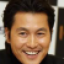

1 1


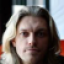

0 1


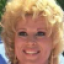

0 1


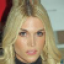

1 1


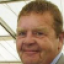

0 1


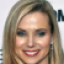

0 1


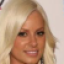

0 1


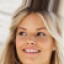

0 1


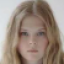

0 1


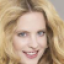

1 2


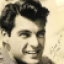

0 2


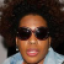

1 2


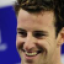

1 2


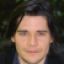

0 1


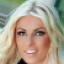

1 2


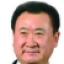

0 1


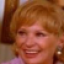

0 1


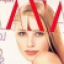

1 2


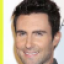

1 2


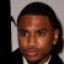

0 1


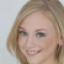

1 2


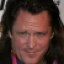

0 1


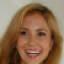

1 1


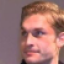

0 1


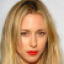

0 1


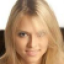

0 1


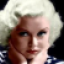

0 1


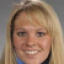

1 1


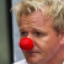

1 2


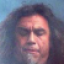

1 2


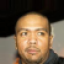

0 1


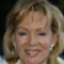

1 2


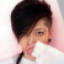

1 2


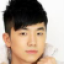

1 1


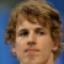

0 1


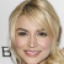

In [6]:
InvNorm = ffcv_utils.inv_norm(hparams['mean'], hparams['std'])
for b in range(100):
    img = batch[0][b]
    print(batch[1][b].item(), (batch[2][b].item()))
    display(torchvision.transforms.ToPILImage()(InvNorm(img)))